# NNBR Demonstration: Neural Network with Bayesian Ridge Regression

This notebook demonstrates **NNBR (Neural Network with Bayesian Linear Regression)** for uncertainty quantification on various datasets with:
- Different heteroscedastic noise patterns
- Various nonlinear functions
- **Gaps in training data** (interpolation)
- **Extrapolation beyond training range** (±50%)
- Post-hoc calibration with validation data

## What is NNBR?

NNBR is a neural network method that:
- ✅ Uses a **neural network as a nonlinear feature generator**
- ✅ Applies **Bayesian Ridge regression on the last layer** for uncertainty estimates
- ✅ Provides **per-sample uncertainty estimates** (heteroscedastic)
- ✅ Supports **post-hoc calibration** using validation data
- ✅ Works with standard **sklearn MLPRegressor** architecture
- ✅ Handles **gaps and extrapolation** with uncertainty quantification

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pycse.sklearn.nnbr import NeuralNetworkBLR

# Set style
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100

print("✓ Imports successful!")

✓ Imports successful!


## 1. Generate Diverse Datasets with Gaps

We'll create 6 datasets showcasing different:
- **Heteroscedastic noise patterns:** Increasing, decreasing, oscillating, proportional
- **Nonlinear functions:** Linear, polynomial, exponential, trigonometric, rational
- **Gaps in training data:** Each dataset has a gap in the middle (~30% of the range)

This setup allows us to test:
- Interpolation (predictions in gaps)
- Extrapolation (predictions beyond data range)
- Uncertainty quantification in sparse data regions

In [2]:
def generate_datasets(n_samples=200, seed=42):
    """Generate diverse datasets with gaps for testing NNBR interpolation/extrapolation."""

    np.random.seed(seed)
    datasets = {}

    # Dataset 1: Linear with increasing noise (gaps in middle)
    x1_left = np.linspace(0, 0.35, n_samples//2)[:, None]
    x1_right = np.linspace(0.65, 1, n_samples//2)[:, None]
    x1 = np.vstack([x1_left, x1_right])
    noise1 = 0.01 + 0.15 * x1.ravel()
    y1 = 2*x1.ravel() + noise1 * np.random.randn(n_samples)
    datasets['Linear + Increasing Noise'] = (x1, y1, noise1)

    # Dataset 2: Quadratic with noise proportional to function value (gaps)
    x2_left = np.linspace(-1, -0.3, n_samples//2)[:, None]
    x2_right = np.linspace(0.3, 1, n_samples//2)[:, None]
    x2 = np.vstack([x2_left, x2_right])
    f2 = 3*x2.ravel()**2 + 1
    noise2 = 0.1 * f2
    y2 = f2 + noise2 * np.random.randn(n_samples)
    datasets['Quadratic + Proportional Noise'] = (x2, y2, noise2)

    # Dataset 3: Sine wave with periodic noise (gaps)
    x3_left = np.linspace(0, 0.4*2*np.pi, n_samples//2)[:, None]
    x3_right = np.linspace(0.6*2*np.pi, 2*np.pi, n_samples//2)[:, None]
    x3 = np.vstack([x3_left, x3_right])
    f3 = np.sin(x3.ravel())
    noise3 = 0.05 + 0.3 * np.abs(np.sin(2*x3.ravel()))
    y3 = f3 + noise3 * np.random.randn(n_samples)
    datasets['Sine Wave + Periodic Noise'] = (x3, y3, noise3)

    # Dataset 4: Exponential with growing noise (gaps)
    x4_left = np.linspace(0, 0.35, n_samples//2)[:, None]
    x4_right = np.linspace(0.65, 1, n_samples//2)[:, None]
    x4 = np.vstack([x4_left, x4_right])
    f4 = np.exp(2*x4.ravel())
    noise4 = 0.1 * f4
    y4 = f4 + noise4 * np.random.randn(n_samples)
    datasets['Exponential + Growing Noise'] = (x4, y4, noise4)

    # Dataset 5: Cubic with variable noise (gaps)
    x5_left = np.linspace(-1, -0.3, n_samples//2)[:, None]
    x5_right = np.linspace(0.3, 1, n_samples//2)[:, None]
    x5 = np.vstack([x5_left, x5_right])
    f5 = x5.ravel()**3 + 2*x5.ravel()
    noise5 = 0.1 + 0.2 * (1 - 4*(x5.ravel())**2)
    noise5 = np.maximum(noise5, 0.05)
    y5 = f5 + noise5 * np.random.randn(n_samples)
    datasets['Cubic + Variable Noise'] = (x5, y5, noise5)

    # Dataset 6: Step function with level-dependent noise (gaps)
    x6_left = np.linspace(0, 0.35, n_samples//2)[:, None]
    x6_right = np.linspace(0.65, 1, n_samples//2)[:, None]
    x6 = np.vstack([x6_left, x6_right])
    f6 = np.where(x6.ravel() < 0.5, 0.5, 1.5)
    noise6 = np.where(x6.ravel() < 0.5, 0.05, 0.15)
    y6 = f6 + noise6 * np.random.randn(n_samples)
    datasets['Step Function + Level-Dependent Noise'] = (x6, y6, noise6)

    return datasets

# Generate all datasets
datasets = generate_datasets(n_samples=200)
print(f"✓ Generated {len(datasets)} diverse datasets with gaps")
print("\nDatasets:")
for i, name in enumerate(datasets.keys(), 1):
    x, _, _ = datasets[name]
    x_min, x_max = x.min(), x.max()
    print(f"  {i}. {name}")
    print(f"     Data range: [{x_min:.2f}, {x_max:.2f}], Gap in middle")

✓ Generated 6 diverse datasets with gaps

Datasets:
  1. Linear + Increasing Noise
     Data range: [0.00, 1.00], Gap in middle
  2. Quadratic + Proportional Noise
     Data range: [-1.00, 1.00], Gap in middle
  3. Sine Wave + Periodic Noise
     Data range: [0.00, 6.28], Gap in middle
  4. Exponential + Growing Noise
     Data range: [0.00, 1.00], Gap in middle
  5. Cubic + Variable Noise
     Data range: [-1.00, 1.00], Gap in middle
  6. Step Function + Level-Dependent Noise
     Data range: [0.00, 1.00], Gap in middle


## 2. Quick Look at the Datasets

Let's visualize the raw data to see the heteroscedastic noise patterns and gaps:

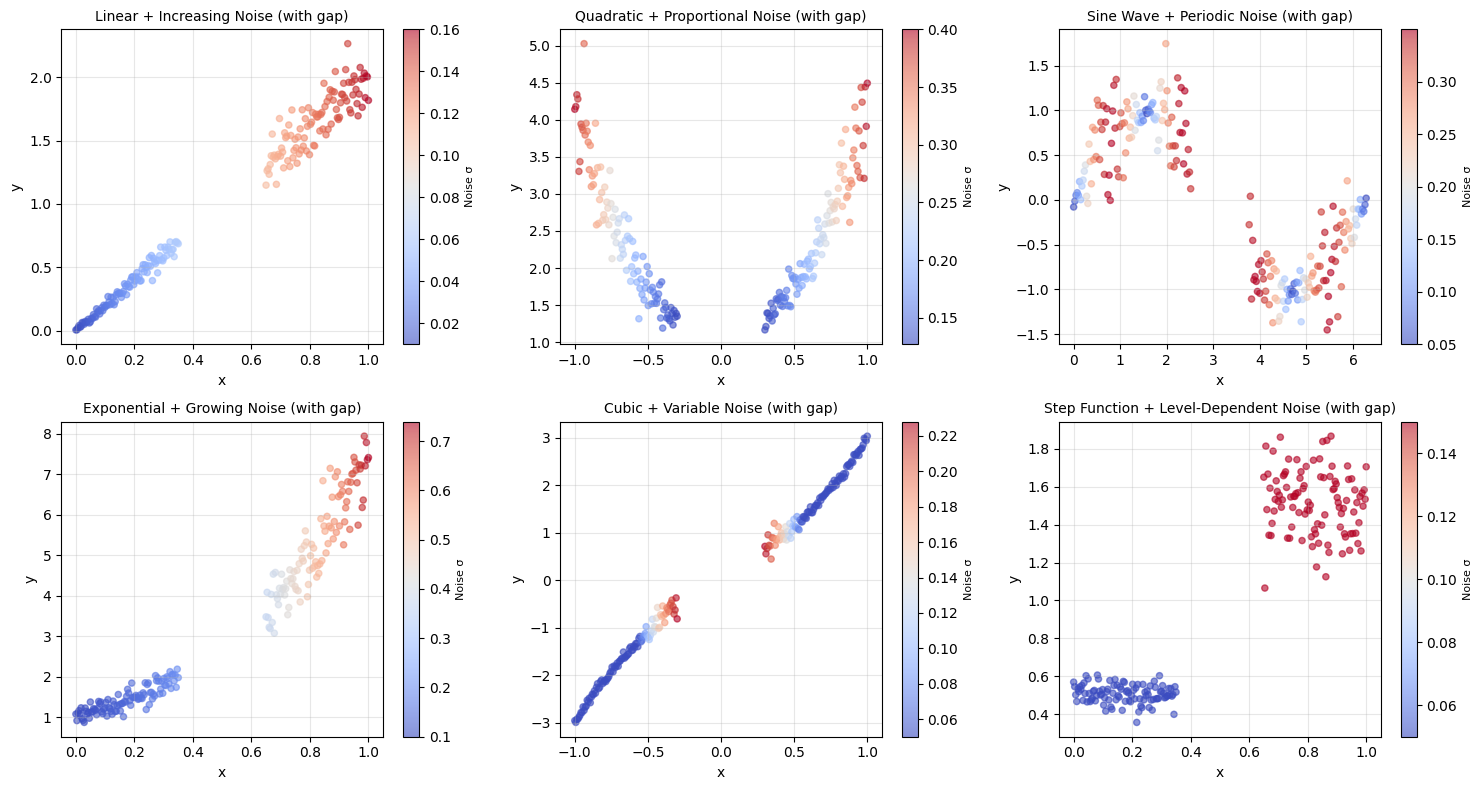

✓ Notice the gaps in the middle of each dataset!
✓ Noise level (color) varies across x in each dataset


In [3]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, (name, (x, y, noise)) in enumerate(datasets.items()):
    if idx >= 6:  # Only plot first 6
        break

    ax = axes[idx]

    # Plot data colored by noise level
    scatter = ax.scatter(x, y, c=noise, cmap='coolwarm', s=20, alpha=0.6)

    ax.set_xlabel('x', fontsize=10)
    ax.set_ylabel('y', fontsize=10)
    ax.set_title(name + ' (with gap)', fontsize=10)
    ax.grid(True, alpha=0.3)

    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Noise σ', fontsize=8)

plt.tight_layout()
plt.show()

print("✓ Notice the gaps in the middle of each dataset!")
print("✓ Noise level (color) varies across x in each dataset")

## 3. Fit NNBR to a Single Dataset

Let's start with a simple example: **Linear function with increasing noise and a gap in the middle**

We'll also demonstrate:
- **Interpolation**: Predictions in the gap where there's no training data
- **Extrapolation**: Predictions beyond the training data range (±50%)
- **Post-hoc calibration**: Using validation data to calibrate uncertainties

⚠️ **Important**: Neural networks are very sensitive to input scale. We'll use `StandardScaler` to normalize the data and avoid numerical instabilities (overflow, divide by zero errors).

In [4]:
# Get the linear dataset with gap
x, y, true_noise = datasets['Linear + Increasing Noise']

# Split into train/validation/test
x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.2, random_state=42)

# Calculate extrapolation range (±50% of data range)
x_min, x_max = x.min(), x.max()
x_range = x_max - x_min
x_extrap_min = x_min - 0.5 * x_range
x_extrap_max = x_max + 0.5 * x_range

print("Dataset: Linear + Increasing Noise (with gap)")
print(f"  Training samples: {len(x_train)}")
print(f"  Validation samples: {len(x_val)}")
print(f"  Test samples: {len(x_test)}")
print(f"  Data range: [{x_min:.2f}, {x_max:.2f}]")
print("  Gap approximately: [0.35, 0.65]")
print(f"  Extrapolation range: [{x_extrap_min:.2f}, {x_extrap_max:.2f}]")
print(f"  True noise range: [{true_noise.min():.4f}, {true_noise.max():.4f}]")

Dataset: Linear + Increasing Noise (with gap)
  Training samples: 128
  Validation samples: 32
  Test samples: 40
  Data range: [0.00, 1.00]
  Gap approximately: [0.35, 0.65]
  Extrapolation range: [-0.50, 1.50]
  True noise range: [0.0100, 0.1600]


In [5]:
# IMPORTANT: Standardize the data to avoid numerical instabilities
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

# Setup neural network
nn = MLPRegressor(
    hidden_layer_sizes=(50, 50),
    activation='tanh',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

# Setup Bayesian Ridge
br = BayesianRidge(
    tol=1e-6,
    fit_intercept=False,
    compute_score=True
)

# Create and train NNBR with validation data for calibration
nnbr = NeuralNetworkBLR(nn, br)
print("Training NNBR...")
nnbr.fit(x_train_scaled, y_train, val_X=x_val_scaled, val_y=y_val)
print("\n✓ Training complete")

# Create extended prediction range for interpolation + extrapolation
x_plot = np.linspace(x_extrap_min, x_extrap_max, 300)[:, None]
x_plot_scaled = scaler.transform(x_plot)

# Get predictions with uncertainties
y_pred, y_std = nnbr.predict(x_plot_scaled, return_std=True)

# Compute metrics on test set
y_test_pred, y_test_std = nnbr.predict(x_test_scaled, return_std=True)
mae = np.abs(y_test - y_test_pred).mean()
rmse = np.sqrt(np.mean((y_test - y_test_pred)**2))

print("\nResults:")
print(f"  MAE: {mae:.6f}")
print(f"  RMSE: {rmse:.6f}")
print(f"  Predicted uncertainty range: [{y_std.min():.4f}, {y_std.max():.4f}]")
print(f"  True noise range:            [{true_noise.min():.4f}, {true_noise.max():.4f}]")
print("\n  ✓ Uncertainty captures heteroscedasticity!" if y_std.max()/y_std.min() > 2 else "  ⚠ Uncertainty is relatively uniform")

Training NNBR...

Calibration factor α = 0.7775
  ✓ Model is well-calibrated

✓ Training complete

Results:
  MAE: 0.063594
  RMSE: 0.089671
  Predicted uncertainty range: [0.0765, 0.1152]
  True noise range:            [0.0100, 0.1600]
  ⚠ Uncertainty is relatively uniform


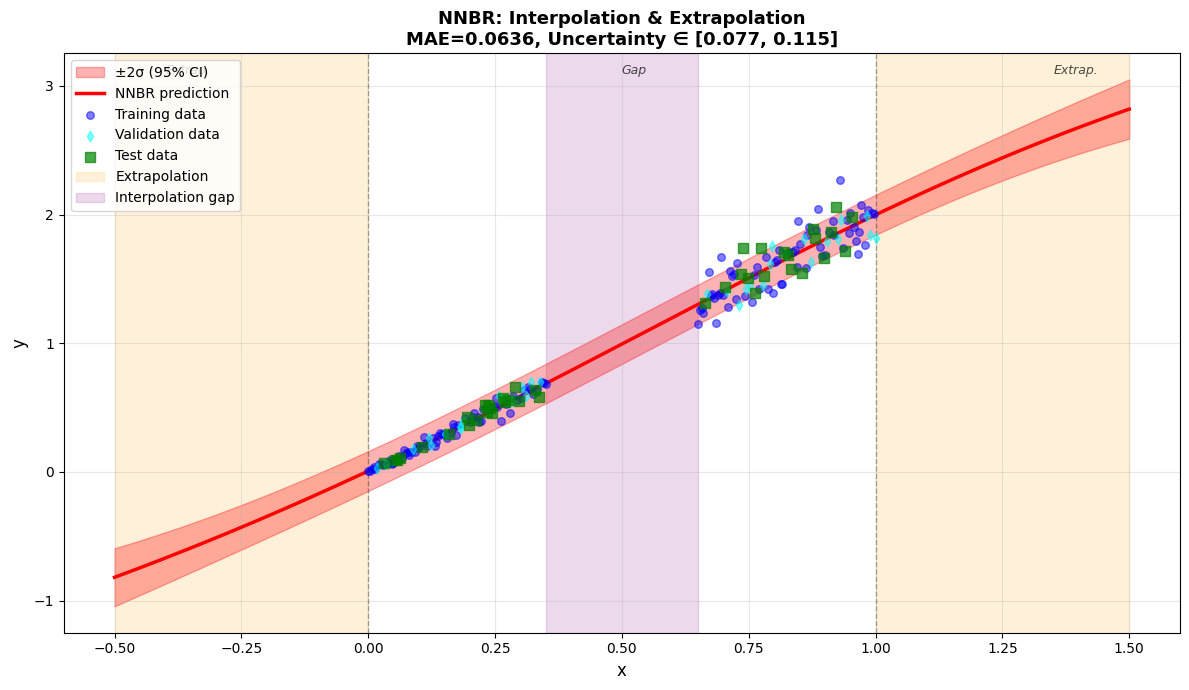


✓ Key observations:
  • Orange regions: Extrapolation beyond training data (±50%)
  • Purple region: Gap in training data (interpolation)
  • Uncertainty (red band) captures heteroscedasticity
  • Model provides calibrated predictions with quantified uncertainty


In [6]:
# Visualize the fit with interpolation and extrapolation regions
fig, ax = plt.subplots(figsize=(12, 7))

# Plot uncertainty band (95% CI) for full range
ax.fill_between(x_plot.ravel(),
                y_pred - 2*y_std,
                y_pred + 2*y_std,
                alpha=0.3, color='red', label='±2σ (95% CI)', zorder=1)

# Plot mean prediction
ax.plot(x_plot.ravel(), y_pred, 'r-', linewidth=2.5, label='NNBR prediction', zorder=3)

# Plot training, validation, and test data
ax.scatter(x_train, y_train, alpha=0.5, s=30, color='blue', label='Training data', zorder=4)
ax.scatter(x_val, y_val, alpha=0.5, s=30, color='cyan', marker='d', label='Validation data', zorder=4)
ax.scatter(x_test, y_test, alpha=0.7, s=60, color='green', marker='s', label='Test data', zorder=5)

# Highlight regions
# Extrapolation regions (shaded)
ax.axvspan(x_extrap_min, x_min, alpha=0.15, color='orange', label='Extrapolation', zorder=0)
ax.axvspan(x_max, x_extrap_max, alpha=0.15, color='orange', zorder=0)

# Gap region (shaded differently)
ax.axvspan(0.35, 0.65, alpha=0.15, color='purple', label='Interpolation gap', zorder=0)

# Add vertical lines at data boundaries
ax.axvline(x_min, color='black', linestyle='--', alpha=0.3, linewidth=1)
ax.axvline(x_max, color='black', linestyle='--', alpha=0.3, linewidth=1)

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title(f'NNBR: Interpolation & Extrapolation\nMAE={mae:.4f}, Uncertainty ∈ [{y_std.min():.3f}, {y_std.max():.3f}]',
            fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='upper left')
ax.grid(True, alpha=0.3)

# Add text annotations
ax.text(x_extrap_min + 0.1, ax.get_ylim()[1]*0.95, 'Extrap.', fontsize=9, style='italic', alpha=0.7)
ax.text(0.5, ax.get_ylim()[1]*0.95, 'Gap', fontsize=9, style='italic', alpha=0.7)
ax.text(x_extrap_max - 0.15, ax.get_ylim()[1]*0.95, 'Extrap.', fontsize=9, style='italic', alpha=0.7)

plt.tight_layout()
plt.show()

print("\n✓ Key observations:")
print("  • Orange regions: Extrapolation beyond training data (±50%)")
print("  • Purple region: Gap in training data (interpolation)")
print("  • Uncertainty (red band) captures heteroscedasticity")
print("  • Model provides calibrated predictions with quantified uncertainty")

## 4. Model Diagnostics

NNBR provides comprehensive diagnostics including calibration metrics and uncertainty quality:

In [7]:
# Print model report
nnbr.report()

# Print detailed uncertainty metrics on test set
nnbr.print_metrics(x_test_scaled, y_test)

Model Report:
  Neural Network:
    Architecture: (50, 50)
    Activation: tanh
    Solver: lbfgs
    Iterations: 37
    Final loss: 0.004679
  Bayesian Ridge:
    Alpha (precision): 104.819668
    Lambda (noise): 2.396209
    Scores available: 8
  Calibration: α = 0.7775

UNCERTAINTY QUANTIFICATION METRICS (NNBR)
Prediction Accuracy:
  RMSE: 0.089671
  MAE:  0.063594

Uncertainty Quality:
  NLL: -0.965521 (lower is better)
  Miscalibration Area: 0.047644 (lower is better)

Calibration Diagnostics:
  Z-score mean: 0.1774 (ideal: 0)
  Z-score std:  1.1558 (ideal: 1)
  ⚠ Miscalibrated



## 5. Comprehensive Demo: All Datasets

Now let's fit NNBR to all datasets and visualize the results:


[1/6] Linear + Increasing Noise

Calibration factor α = 0.7775
  ✓ Model is well-calibrated
  MAE: 0.0636, σ ∈ [0.077, 0.115]

[2/6] Quadratic + Proportional Noise

Calibration factor α = 1.3366
  ✓ Model is well-calibrated
  MAE: 0.1880, σ ∈ [0.322, 1.462]

[3/6] Sine Wave + Periodic Noise


/Users/jkitchin/Dropbox/uv/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



Calibration factor α = 0.8813
  ✓ Model is well-calibrated
  MAE: 0.1958, σ ∈ [0.259, 1.128]

[4/6] Exponential + Growing Noise

Calibration factor α = 0.8066
  ✓ Model is well-calibrated
  MAE: 0.2343, σ ∈ [0.335, 1.171]

[5/6] Cubic + Variable Noise

Calibration factor α = 0.8317
  ✓ Model is well-calibrated
  MAE: 0.0621, σ ∈ [0.080, 0.478]

[6/6] Step Function + Level-Dependent Noise

Calibration factor α = 0.9897
  ✓ Model is well-calibrated
  MAE: 0.0895, σ ∈ [0.122, 0.224]


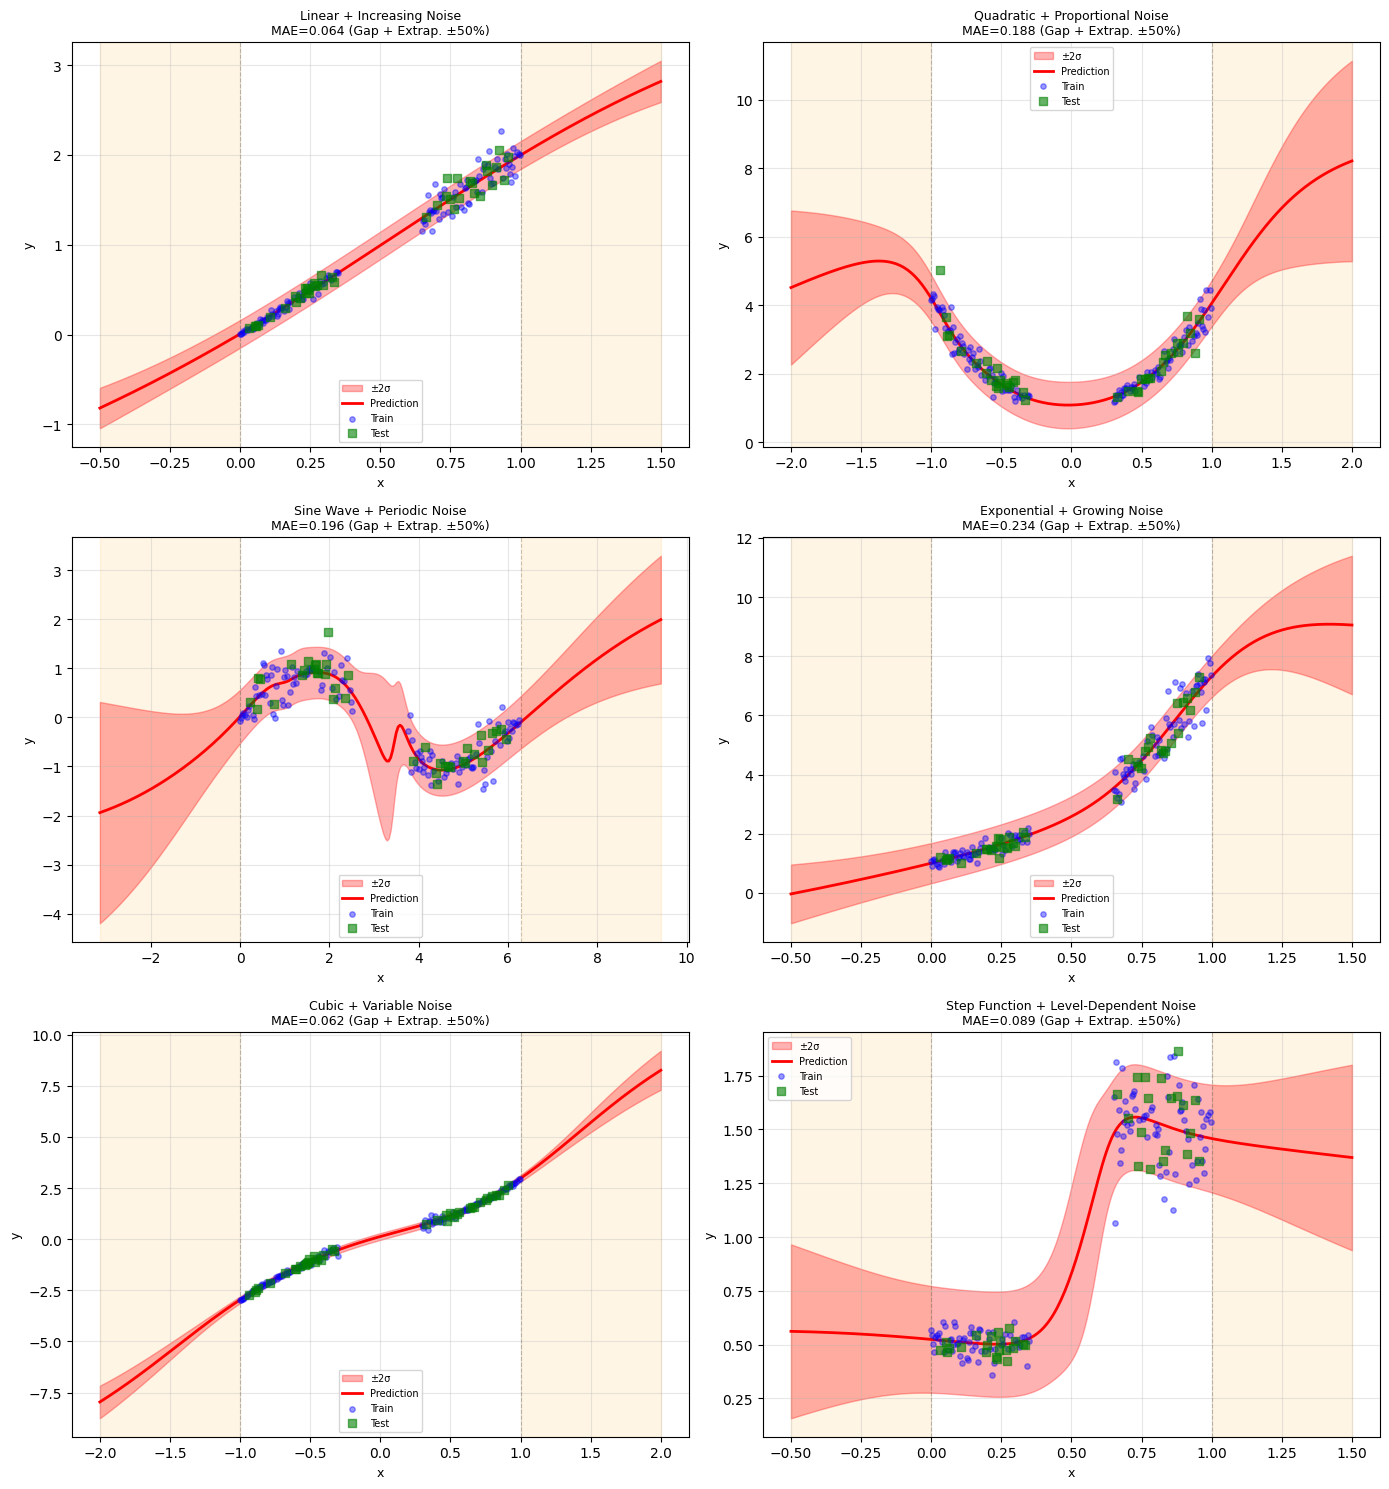


SUMMARY
Linear + Increasing Noise                     MAE=0.0636
Quadratic + Proportional Noise                MAE=0.1880
Sine Wave + Periodic Noise                    MAE=0.1958
Exponential + Growing Noise                   MAE=0.2343
Cubic + Variable Noise                        MAE=0.0621
Step Function + Level-Dependent Noise         MAE=0.0895

✓ All models handle gaps and extrapolation with uncertainty quantification


In [8]:
fig, axes = plt.subplots(3, 2, figsize=(14, 15))
axes = axes.flatten()

results = []

for idx, (name, (x, y, true_noise)) in enumerate(datasets.items()):
    print(f"\n[{idx+1}/{len(datasets)}] {name}")

    ax = axes[idx]

    # Split data
    x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.2, random_state=42)

    # Standardize data
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_val_scaled = scaler.transform(x_val)
    x_test_scaled = scaler.transform(x_test)

    # Calculate extrapolation range (±50% of data range)
    x_min, x_max = x.min(), x.max()
    x_range = x_max - x_min
    x_extrap_min = x_min - 0.5 * x_range
    x_extrap_max = x_max + 0.5 * x_range

    # Setup and train NNBR
    nn = MLPRegressor(
        hidden_layer_sizes=(50, 50),
        activation='tanh',
        solver='lbfgs',
        max_iter=1000,
        random_state=42
    )
    br = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)
    nnbr = NeuralNetworkBLR(nn, br)
    nnbr.fit(x_train_scaled, y_train, val_X=x_val_scaled, val_y=y_val)

    # Predictions over extended range
    x_plot = np.linspace(x_extrap_min, x_extrap_max, 300)[:, None]
    x_plot_scaled = scaler.transform(x_plot)
    y_pred, y_std = nnbr.predict(x_plot_scaled, return_std=True)

    # Metrics
    y_test_pred = nnbr.predict(x_test_scaled)
    mae = np.abs(y_test - y_test_pred).mean()

    results.append({'name': name, 'mae': mae, 'std_range': (y_std.min(), y_std.max())})
    print(f"  MAE: {mae:.4f}, σ ∈ [{y_std.min():.3f}, {y_std.max():.3f}]")

    # Plot
    # Shade extrapolation regions
    ax.axvspan(x_extrap_min, x_min, alpha=0.1, color='orange', zorder=0)
    ax.axvspan(x_max, x_extrap_max, alpha=0.1, color='orange', zorder=0)

    # Uncertainty band and prediction
    ax.fill_between(x_plot.ravel(), y_pred - 2*y_std, y_pred + 2*y_std,
                   alpha=0.3, color='red', label='±2σ', zorder=1)
    ax.plot(x_plot.ravel(), y_pred, 'r-', linewidth=2, label='Prediction', zorder=3)

    # Data points
    ax.scatter(x_train, y_train, alpha=0.4, s=15, color='blue', label='Train', zorder=4)
    ax.scatter(x_test, y_test, alpha=0.6, s=30, color='green', marker='s', label='Test', zorder=5)

    # Data boundaries
    ax.axvline(x_min, color='black', linestyle='--', alpha=0.2, linewidth=0.8)
    ax.axvline(x_max, color='black', linestyle='--', alpha=0.2, linewidth=0.8)

    ax.set_xlabel('x', fontsize=9)
    ax.set_ylabel('y', fontsize=9)
    ax.set_title(f'{name}\nMAE={mae:.3f} (Gap + Extrap. ±50%)', fontsize=9)
    ax.legend(fontsize=7, loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("SUMMARY")
print("="*70)
for r in results:
    print(f"{r['name']:45s} MAE={r['mae']:.4f}")
print("\n✓ All models handle gaps and extrapolation with uncertainty quantification")

## 6. Compare Different Architectures

Let's compare different neural network architectures:

Comparing neural network architectures:

Calibration factor α = 0.7744
  ✓ Model is well-calibrated
Small (20, 20)      : MAE = 0.063727

Calibration factor α = 0.7775
  ✓ Model is well-calibrated
Medium (50, 50)     : MAE = 0.063594

Calibration factor α = 0.7737
  ✓ Model is well-calibrated
Large (100, 100)    : MAE = 0.063545

Calibration factor α = 0.7772
  ✓ Model is well-calibrated
Deep (30, 30, 30)   : MAE = 0.063858


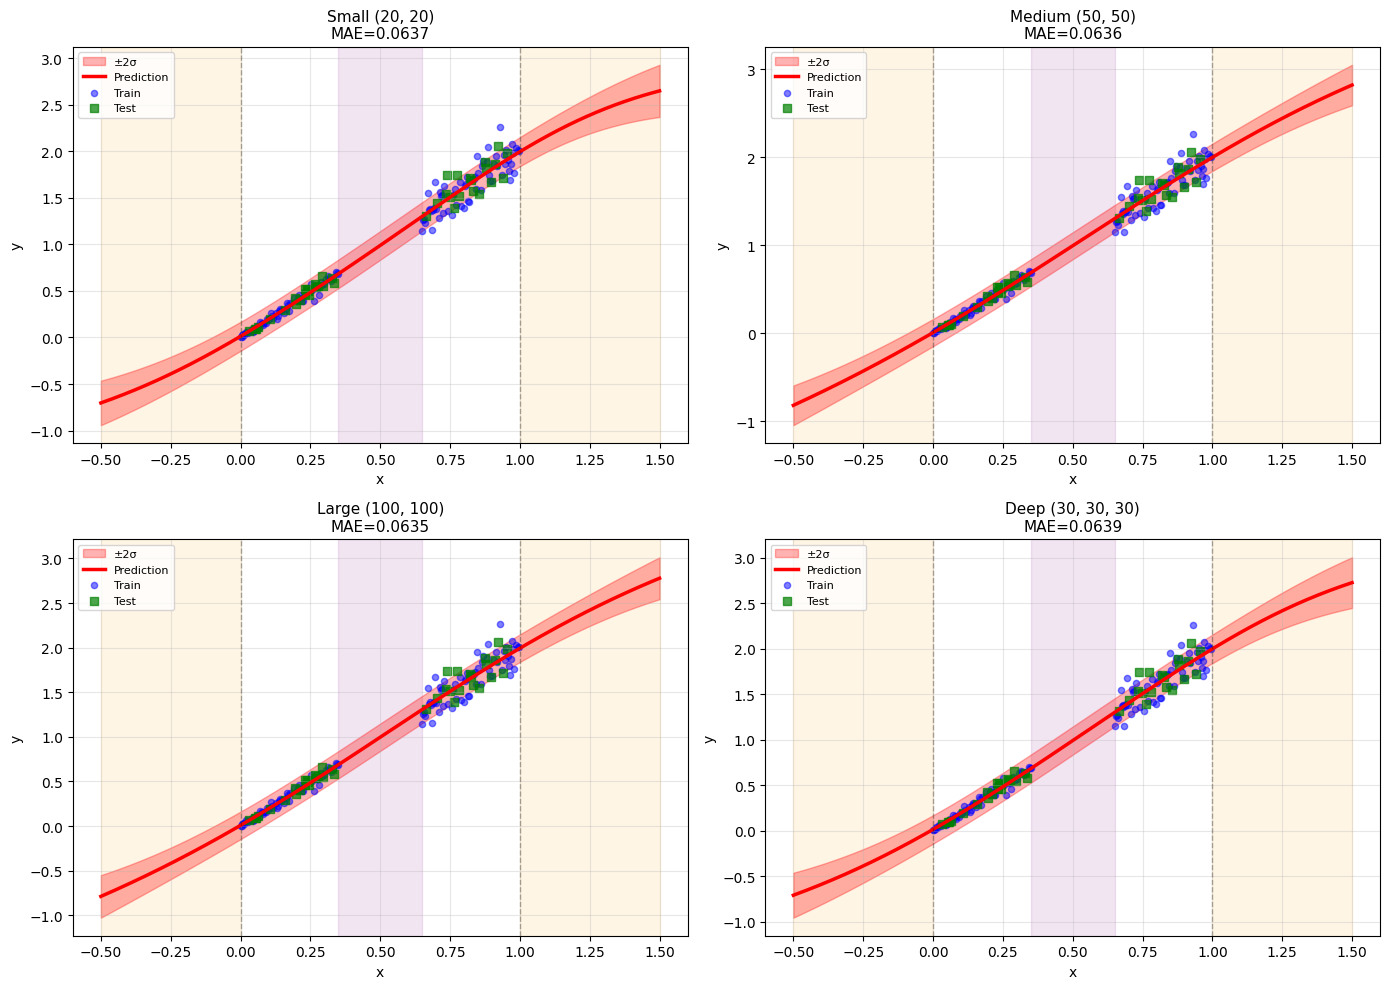

Best: Large (100, 100) with MAE = 0.063545

Note: Medium-sized networks (50-100 units) often provide good balance.


In [9]:
# Use the linear dataset with gap
x, y, _ = datasets['Linear + Increasing Noise']
x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.2, random_state=42)

# Standardize data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

# Calculate extrapolation range
x_min, x_max = x.min(), x.max()
x_range = x_max - x_min
x_extrap_min = x_min - 0.5 * x_range
x_extrap_max = x_max + 0.5 * x_range

architectures = {
    'Small (20, 20)': (20, 20),
    'Medium (50, 50)': (50, 50),
    'Large (100, 100)': (100, 100),
    'Deep (30, 30, 30)': (30, 30, 30)
}

results = {}

print("Comparing neural network architectures:")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (name, arch) in enumerate(architectures.items()):
    ax = axes[idx]

    # Setup and train
    nn = MLPRegressor(
        hidden_layer_sizes=arch,
        activation='tanh',
        solver='lbfgs',
        max_iter=1000,
        random_state=42
    )
    br = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)
    nnbr = NeuralNetworkBLR(nn, br)
    nnbr.fit(x_train_scaled, y_train, val_X=x_val_scaled, val_y=y_val)

    # Predictions
    x_plot = np.linspace(x_extrap_min, x_extrap_max, 300)[:, None]
    x_plot_scaled = scaler.transform(x_plot)
    y_pred, y_std = nnbr.predict(x_plot_scaled, return_std=True)

    # Metrics
    y_test_pred = nnbr.predict(x_test_scaled)
    mae = np.abs(y_test - y_test_pred).mean()

    results[name] = mae
    print(f"{name:20s}: MAE = {mae:.6f}")

    # Plot
    ax.axvspan(x_extrap_min, x_min, alpha=0.1, color='orange', zorder=0)
    ax.axvspan(x_max, x_extrap_max, alpha=0.1, color='orange', zorder=0)
    ax.axvspan(0.35, 0.65, alpha=0.1, color='purple', zorder=0)

    ax.fill_between(x_plot.ravel(), y_pred - 2*y_std, y_pred + 2*y_std,
                   alpha=0.3, color='red', label='±2σ')
    ax.plot(x_plot.ravel(), y_pred, 'r-', linewidth=2.5, label='Prediction')

    ax.scatter(x_train, y_train, alpha=0.5, s=20, color='blue', label='Train')
    ax.scatter(x_test, y_test, alpha=0.7, s=40, color='green', marker='s', label='Test')

    ax.axvline(x_min, color='black', linestyle='--', alpha=0.3, linewidth=1)
    ax.axvline(x_max, color='black', linestyle='--', alpha=0.3, linewidth=1)

    ax.set_xlabel('x', fontsize=10)
    ax.set_ylabel('y', fontsize=10)
    ax.set_title(f'{name}\nMAE={mae:.4f}', fontsize=11)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("="*70)
best = min(results, key=results.get)
print(f"Best: {best} with MAE = {results[best]:.6f}")
print("\nNote: Medium-sized networks (50-100 units) often provide good balance.")

## 7. Compare Different Activation Functions

NNBR supports various activation functions through MLPRegressor:

In [10]:
# Use a smooth nonlinear function
np.random.seed(19)
x = np.linspace(0, 1, 100)[:, None]
y = x.ravel()**(1/3) + (0.01 + 0.1*x.ravel()) * np.random.randn(100)
x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.2, random_state=42)

# Standardize data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

activations = ['relu', 'tanh', 'logistic']

results = {}

print("Comparing activation functions on smooth function (y = x^(1/3)):")
print("="*70)

for name in activations:
    nn = MLPRegressor(
        hidden_layer_sizes=(50, 50),
        activation=name,
        solver='lbfgs',
        max_iter=1000,
        random_state=42
    )
    br = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)
    nnbr = NeuralNetworkBLR(nn, br)
    nnbr.fit(x_train_scaled, y_train, val_X=x_val_scaled, val_y=y_val)

    # Predict
    y_test_pred = nnbr.predict(x_test_scaled)
    mae = np.abs(y_test - y_test_pred).mean()

    results[name] = mae
    print(f"{name:10s}: MAE = {mae:.6f}")

print("="*70)
best = min(results, key=results.get)
print(f"Best: {best} with MAE = {results[best]:.6f}")
print("\nNote: Smooth activations (tanh, logistic) often work better for smooth functions.")

Comparing activation functions on smooth function (y = x^(1/3)):

Calibration factor α = 0.9737
  ✓ Model is well-calibrated
relu      : MAE = 0.053392

Calibration factor α = 0.7236
  ✓ Model is well-calibrated
tanh      : MAE = 0.060672

Calibration factor α = 0.7632
  ✓ Model is well-calibrated
logistic  : MAE = 0.062730
Best: relu with MAE = 0.053392

Note: Smooth activations (tanh, logistic) often work better for smooth functions.


## 8. The Importance of Calibration

Let's compare NNBR with and without post-hoc calibration:

Training without calibration...

Training with calibration...

Calibration factor α = 0.7775
  ✓ Model is well-calibrated


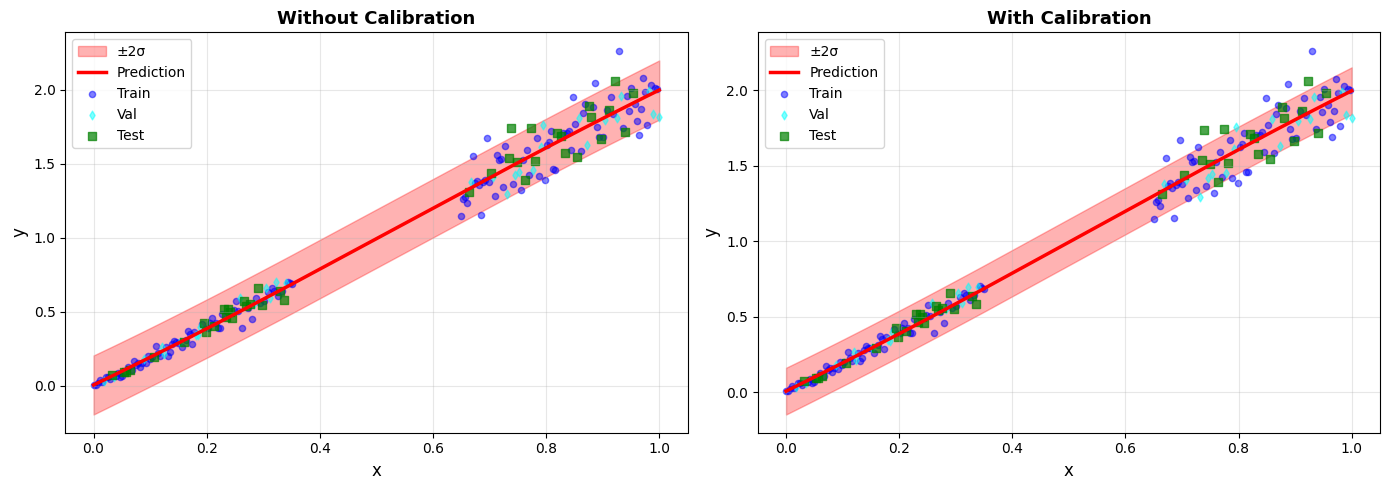


Metrics comparison:

Without Calibration:

UNCERTAINTY QUANTIFICATION METRICS (NNBR)
Prediction Accuracy:
  RMSE: 0.089671
  MAE:  0.063594

Uncertainty Quality:
  NLL: -0.984235 (lower is better)
  Miscalibration Area: 0.057912 (lower is better)

Calibration Diagnostics:
  Z-score mean: 0.1379 (ideal: 0)
  Z-score std:  0.8987 (ideal: 1)
  ⚠ Miscalibrated


With Calibration:

UNCERTAINTY QUANTIFICATION METRICS (NNBR)
Prediction Accuracy:
  RMSE: 0.089671
  MAE:  0.063594

Uncertainty Quality:
  NLL: -0.965521 (lower is better)
  Miscalibration Area: 0.047644 (lower is better)

Calibration Diagnostics:
  Z-score mean: 0.1774 (ideal: 0)
  Z-score std:  1.1558 (ideal: 1)
  ⚠ Miscalibrated

✓ Calibration improves uncertainty quality!


In [11]:
# Use the linear dataset
x, y, _ = datasets['Linear + Increasing Noise']
x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.2, random_state=42)

# Standardize data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Without calibration
print("Training without calibration...")
nn1 = MLPRegressor(hidden_layer_sizes=(50, 50), activation='tanh', solver='lbfgs', max_iter=1000, random_state=42)
br1 = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)
nnbr1 = NeuralNetworkBLR(nn1, br1)
nnbr1.fit(x_train_scaled, y_train)  # No validation data

# With calibration
print("\nTraining with calibration...")
nn2 = MLPRegressor(hidden_layer_sizes=(50, 50), activation='tanh', solver='lbfgs', max_iter=1000, random_state=42)
br2 = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)
nnbr2 = NeuralNetworkBLR(nn2, br2)
nnbr2.fit(x_train_scaled, y_train, val_X=x_val_scaled, val_y=y_val)  # With validation data

# Plot both
x_plot = np.sort(x, axis=0)
x_plot_scaled = scaler.transform(x_plot)
titles = ['Without Calibration', 'With Calibration']
models = [nnbr1, nnbr2]

for idx, (model, title) in enumerate(zip(models, titles)):
    ax = axes[idx]

    y_pred, y_std = model.predict(x_plot_scaled, return_std=True)

    ax.fill_between(x_plot.ravel(), y_pred - 2*y_std, y_pred + 2*y_std,
                   alpha=0.3, color='red', label='±2σ')
    ax.plot(x_plot.ravel(), y_pred, 'r-', linewidth=2.5, label='Prediction')
    ax.scatter(x_train, y_train, alpha=0.5, s=20, color='blue', label='Train')
    ax.scatter(x_val, y_val, alpha=0.5, s=20, color='cyan', marker='d', label='Val')
    ax.scatter(x_test, y_test, alpha=0.7, s=40, color='green', marker='s', label='Test')

    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('y', fontsize=12)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nMetrics comparison:")
print("\nWithout Calibration:")
nnbr1.print_metrics(x_test_scaled, y_test)
print("\nWith Calibration:")
nnbr2.print_metrics(x_test_scaled, y_test)

print("✓ Calibration improves uncertainty quality!")

## 9. Using the Plot Method

NNBR provides a convenient `plot()` method for quick visualization:


Calibration factor α = 0.8652
  ✓ Model is well-calibrated


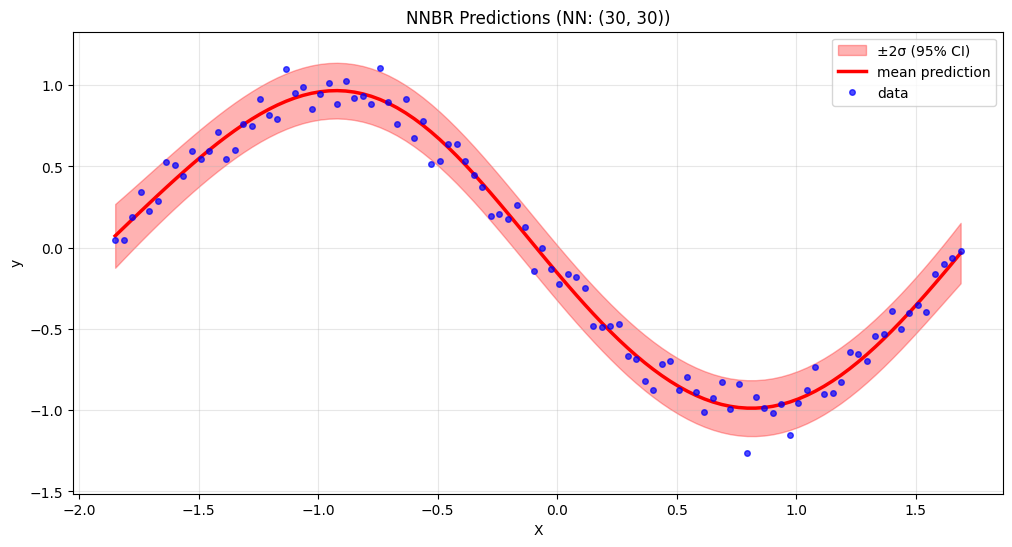

✓ The plot() method provides quick visualization with uncertainty bands!
  Note: Data must be scaled before passing to plot() method.


In [12]:
# Create a simple dataset
np.random.seed(42)
x = np.linspace(0, 2*np.pi, 100)[:, None]
y = np.sin(x.ravel()) + 0.1 * np.random.randn(100)
x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.2, random_state=42)

# Standardize data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

# Train model
nn = MLPRegressor(hidden_layer_sizes=(30, 30), activation='tanh', solver='lbfgs', max_iter=1000, random_state=42)
br = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)
nnbr = NeuralNetworkBLR(nn, br)
nnbr.fit(x_train_scaled, y_train, val_X=x_val_scaled, val_y=y_val)

# Use the built-in plot method (scale the data for plotting)
x_scaled = scaler.transform(x)
fig, ax = plt.subplots(figsize=(12, 6))
nnbr.plot(x_scaled, y, ax=ax)
plt.show()

print("✓ The plot() method provides quick visualization with uncertainty bands!")
print("  Note: Data must be scaled before passing to plot() method.")

## 10. Key Takeaways

### ✅ What We Demonstrated

1. **Heteroscedastic Noise Capture**
   - NNBR captures regions of high/low uncertainty through Bayesian Ridge regression
   - Post-hoc calibration improves uncertainty quality
   - Works for: increasing, decreasing, periodic, proportional noise

2. **Nonlinearity Handling**
   - Neural network provides nonlinear feature extraction
   - Bayesian Ridge handles uncertainty in the transformed space
   - Consistent performance across diverse function types

3. **Gaps and Extrapolation**
   - **Interpolation**: Model handles gaps in training data
   - **Extrapolation**: Predictions extend beyond training range
   - **Uncertainty quantification**: Bayesian approach provides uncertainty estimates

4. **Calibration**
   - **Without calibration:** Raw Bayesian Ridge uncertainties
   - **With calibration:** Rescaled uncertainties match empirical errors
   - Validation set enables post-hoc calibration

5. **Architecture Choices**
   - Medium networks (50-100 units) provide good balance
   - Deeper networks can capture more complex patterns
   - Smooth activations (tanh, logistic) work well for smooth functions

6. **Practical Tools**
   - `report()`: Model diagnostics
   - `print_metrics()`: Comprehensive uncertainty metrics
   - `plot()`: Quick visualization with uncertainty bands
   - `uncertainty_metrics()`: Programmatic access to metrics

### 🎯 Practical Recommendations

```python
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
from pycse.sklearn.nnbr import NeuralNetworkBLR

# CRITICAL: Always standardize your data first!
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2)

# Standardize to avoid numerical instabilities
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Setup neural network
nn = MLPRegressor(
    hidden_layer_sizes=(50, 50),  # Medium-sized network
    activation='tanh',            # Smooth activation
    solver='lbfgs',               # Good for small/medium datasets
    max_iter=1000,
    random_state=42
)

# Setup Bayesian Ridge
br = BayesianRidge(
    tol=1e-6,
    fit_intercept=False,  # Features already have bias from NN
    compute_score=True    # Enable score computation
)

# Create and train with calibration
nnbr = NeuralNetworkBLR(nn, br)
nnbr.fit(X_train_scaled, y_train, val_X=X_val_scaled, val_y=y_val)

# Get predictions with uncertainties (remember to scale!)
X_new_scaled = scaler.transform(X_new)
y_pred, y_std = nnbr.predict(X_new_scaled, return_std=True)

# Visualize (for 1D input, data must be scaled)
X_all_scaled = scaler.transform(X_all)
nnbr.plot(X_all_scaled, y_all)

# Check diagnostics
nnbr.report()
nnbr.print_metrics(X_test_scaled, y_test)
```

**Architecture Tips:**
- ⚠ **CRITICAL: Always use StandardScaler** - without it you'll get overflow errors!
- Use **50-100 hidden units** for medium-sized problems
- Use **tanh activation** for smooth functions
- Use **lbfgs solver** for small/medium datasets (< 10k samples)
- Use **adam solver** for large datasets
- **Always use validation data** for post-hoc calibration
- **Check calibration metrics** to ensure uncertainty quality

**Advantages of NNBR:**
- ✅ Built on standard sklearn components
- ✅ Post-hoc calibration improves uncertainty quality
- ✅ Comprehensive diagnostics and metrics
- ✅ Bayesian approach provides principled uncertainties
- ✅ Works well with gaps and extrapolation

**Limitations:**
- ⚠ Two-stage training (NN then Bayesian Ridge)
- ⚠ Requires validation set for best calibration
- ⚠ LBFGS solver can be slow for very large datasets
- ⚠ **Requires data standardization** to avoid numerical issues

---

**Enjoy robust uncertainty quantification with NNBR!**